In [2]:
import pvdeg
import pandas as pd
import xarray as xr
from dask.distributed import LocalCluster, Client

In [ ]:
workers = 8

cluster = LocalCluster(
    n_workers=workers,
    processes=6, 
)

client = Client(cluster)

print(client.dashboard_link)

In [ ]:
locationGetter = pvdeg.scenario.GeospatialScenario()

locationGetter.addLocation(
    country="United States", 
    downsample_factor=2, 
)

locationGetter.downselect_CONUS()

geo_weather, geo_meta = locationGetter.geospatial_data()

In [ ]:
@pvdeg.decorators.geospatial_quick_shape(0, ['cycles'])
def calculate_freeze_thaw_cycles(weather_df: pd.DataFrame, meta: dict, temperature_col='temp_air'):
    """
    Calculate the number of freeze-thaw cycles in a weather DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing weather data.
        temperature_col (str): Name of the column containing air temperature values in Celsius.

    Returns:
        int: Number of freeze-thaw cycles.
    """
    if temperature_col not in weather_df.columns:
        raise ValueError(f"Column '{temperature_col}' not found in DataFrame.")

    # Add a column to indicate if the temperature is below freezing
    weather_df['below_freezing'] = weather_df[temperature_col] < 0

    # Calculate transitions: freeze (False -> True) and thaw (True -> False)
    weather_df['transitions'] = weather_df['below_freezing'].astype(int).diff()

    # Count freeze-thaw cycles (both freeze and thaw transitions)
    freeze_thaw_cycles = ((weather_df['transitions'] == 1) | (weather_df['transitions'] == -1)).sum() // 2

    return pd.DataFrame([freeze_thaw_cycles], columns = ["cycles"])

In [ ]:
template = pvdeg.geospatial.auto_template(
    ds_gids = geo_weather,
    func = calculate_freeze_thaw_cycles
)

res = pvdeg.geospatial.analysis(
    weather_ds = geo_weather,
    meta_df = geo_meta,
    func = calculate_freeze_thaw_cycles,
    template = template
)

In [ ]:
pvdeg.geospatial.plot_sparse_analysis(result=res, data_var="cycles", method="linear")

In [ ]:
res.to_netcdf("freeze-thaw-us.nc", engine="h5netcdf")

In [3]:
res = xr.open_dataset("freeze-thaw-us.nc", engine="h5netcdf")

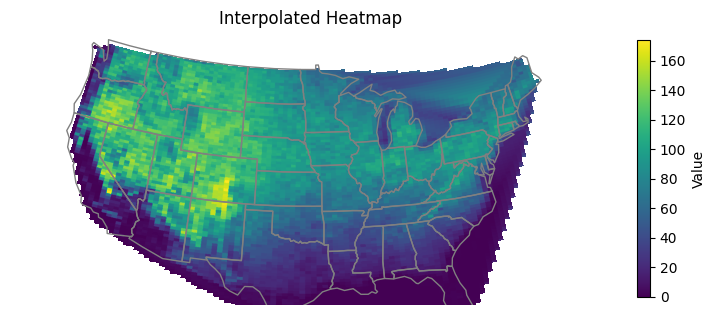

(<Figure size 640x480 with 2 Axes>,
 <GeoAxes: title={'center': 'Interpolated Heatmap'}, xlabel='Longitude', ylabel='Latitude'>)

In [4]:
pvdeg.geospatial.plot_sparse_analysis(result=res, data_var="cycles", method="linear")